# Оптимизация управления персоналом для HR сервиса.


## Пакеты и импорты

In [ ]:
!pip install phik -q
!pip install scikit-learn==0.24.1 -q

In [ ]:
# Импорты
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import shap

from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler,
                                   RobustScaler,
                                   MinMaxScaler,
                                   OrdinalEncoder)
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR
from sklearn.metrics import roc_auc_score, r2_score, make_scorer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import (RandomizedSearchCV,
                                     train_test_split)

from phik.report import plot_correlation_matrix
from phik import phik_matrix
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
RANDOM_STATE = 52

# Оценка индекса удволетворённости сотрудников

**Создание модели регрессии, предсказывающей значение целевого признака 'job_satisfaction_rate'**

`Целевая метрика - SMAPE <= 15`

## Загрузка и первичный анализ данных

In [ ]:
df_train = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')

In [ ]:
df_test1 =  pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
df_test2 =  pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

In [ ]:
df_test1.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [ ]:
df_test2.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [ ]:
df_test = df_test1.merge(df_test2, how='left', on='id')

In [ ]:
df_test

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75
...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,0.56
1996,109582,technology,middle,low,3,no,no,2,21600,0.14
1997,305653,technology,junior,low,1,no,no,3,14400,0.11
1998,160233,technology,middle,low,8,no,no,1,32400,0.43


In [ ]:
df_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 171.9+ KB


### Вывод

**В данных есть Nan, для удобства создана таблица df_test с входным и целевым признаками для тестирования модели. Стандартизация имён столлбцов не требуется.**

## Предобработка

In [ ]:
df_train = df_train.set_index('id')
df_test = df_test.set_index('id')

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   1998 non-null   object 
 1   level                  1999 non-null   object 
 2   workload               2000 non-null   object 
 3   employment_years       2000 non-null   int64  
 4   last_year_promo        2000 non-null   object 
 5   last_year_violations   2000 non-null   object 
 6   supervisor_evaluation  2000 non-null   int64  
 7   salary                 2000 non-null   int64  
 8   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 156.2+ KB


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB


In [ ]:
# Явные дубли
df_train.duplicated().sum()

245

In [ ]:
df_test.duplicated().sum()

83

In [ ]:
df_train = df_train.drop_duplicates()
df_test = df_test.drop_duplicates()

In [ ]:
# Неявные дубли
for i in df_train.select_dtypes(include = 'object').columns:
        print(f'уникальные значения столбца {i} : {df_train[i].unique()}')

уникальные значения столбца dept : ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
уникальные значения столбца level : ['junior' 'middle' 'sinior' nan]
уникальные значения столбца workload : ['medium' 'high' 'low']
уникальные значения столбца last_year_promo : ['no' 'yes']
уникальные значения столбца last_year_violations : ['no' 'yes']


In [ ]:
for i in df_test.select_dtypes(include = 'object').columns:
        print(f'уникальные значения столбца {i} : {df_train[i].unique()}')

уникальные значения столбца dept : ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
уникальные значения столбца level : ['junior' 'middle' 'sinior' nan]
уникальные значения столбца workload : ['medium' 'high' 'low']
уникальные значения столбца last_year_promo : ['no' 'yes']
уникальные значения столбца last_year_violations : ['no' 'yes']


### Вывод:

**Дубликаты удалены, Nan будут заменены с помошью SimpleImputer в пайплайне.**

## Исследовательский анализ

### Численные признаки

In [ ]:
# Автоматизированное изучение кол. признаков

def numgraph(col):
  if col.dtype in ['int64', 'float']:
    fig, axs = plt.subplots(1,2)
    fig.suptitle(f'{str(col.name)}: hist and boxplot')

    sns.histplot(col, bins=10, ax=axs[0])
    axs[0].axvline(col.mean(), color='r')
    axs[0].axvline(col.median(), color='r', linestyle='dashed')

    sns.boxplot(x=col, ax=axs[1])

    plt.show()
    print(col.describe())

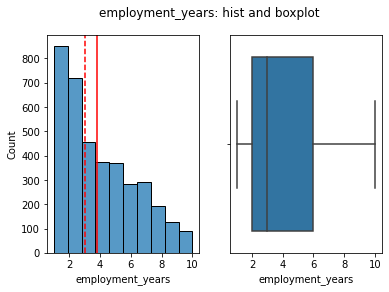

count    3755.000000
mean        3.817044
std         2.557142
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


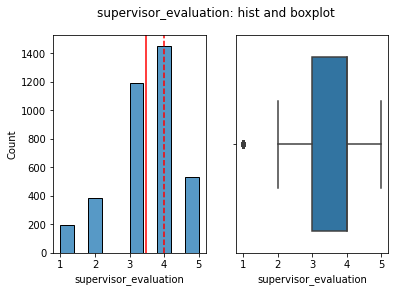

count    3755.000000
mean        3.463648
std         1.026265
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


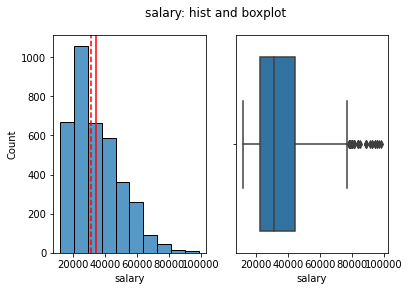

count     3755.000000
mean     34457.416778
std      15050.643870
min      12000.000000
25%      22800.000000
50%      31200.000000
75%      44400.000000
max      98400.000000
Name: salary, dtype: float64


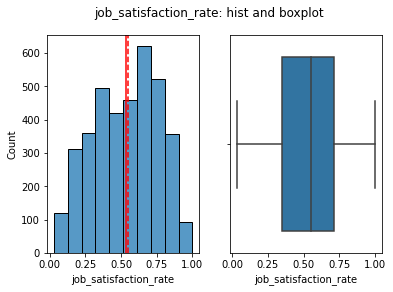

count    3755.000000
mean        0.532554
std         0.226393
min         0.030000
25%         0.350000
50%         0.550000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


In [ ]:
for i in df_train.columns:
    numgraph(df_train[i])

**Признаки распределены нормально(в том числе и целевой), существуют выбивающиеся значения в зарплатах, что, вероятно, связано с меньшинством высокооплачиваемых сотрудников требуется масштабирование при моделировании.**

### Категориальные признаки

In [ ]:
# Автоматизированное изучение кат. признаков


def catgraph(df, col):
    dfg = df.groupby(col.name).size()
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axs[0].pie(dfg, labels=dfg.index, autopct='%1.1f%%')
    axs[0].set_title(f'Pie Chart {col.name}')
    axs[1].bar(dfg.index, dfg)
    axs[1].set_title(f'Bar Chart {col.name}')
    plt.show

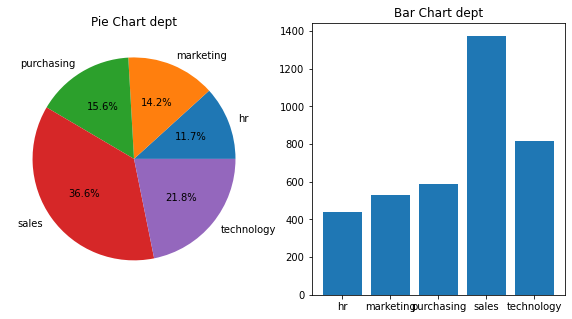

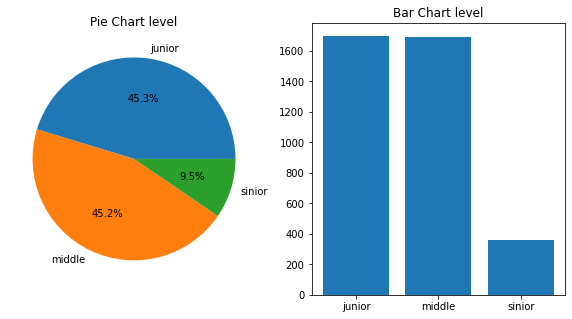

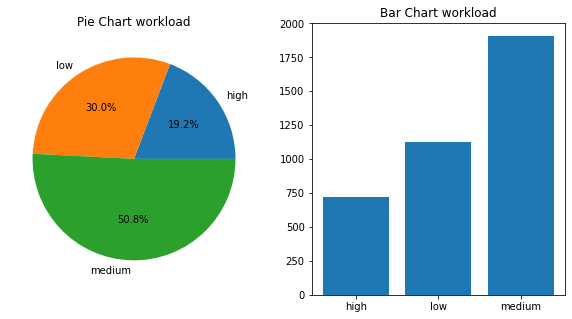

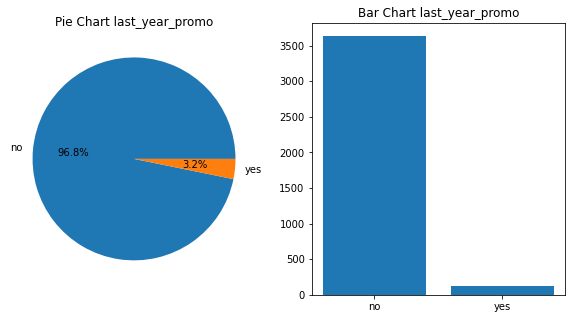

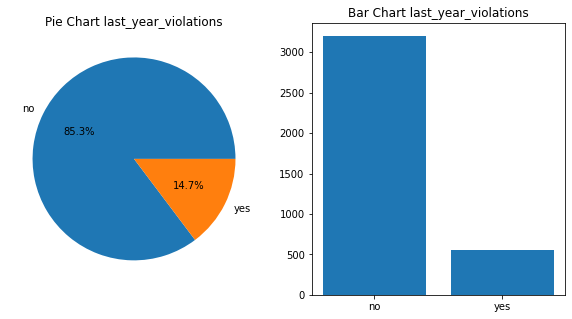

In [ ]:
for i in df_train.select_dtypes(include = 'object').columns:
        catgraph(df_train, df_train[i])

### Вывод:

**Количественные признаки распределены нормально, в том числе и целевой. Однако значения зарплат для высокооплачиваемых сотрудников сильно отличаются от остальных, при этом, таких сотрудников кратно меньше. При моделировании может понадобиться отдельное рассмотрение этого класса персонала.**


## Корреляционный анализ


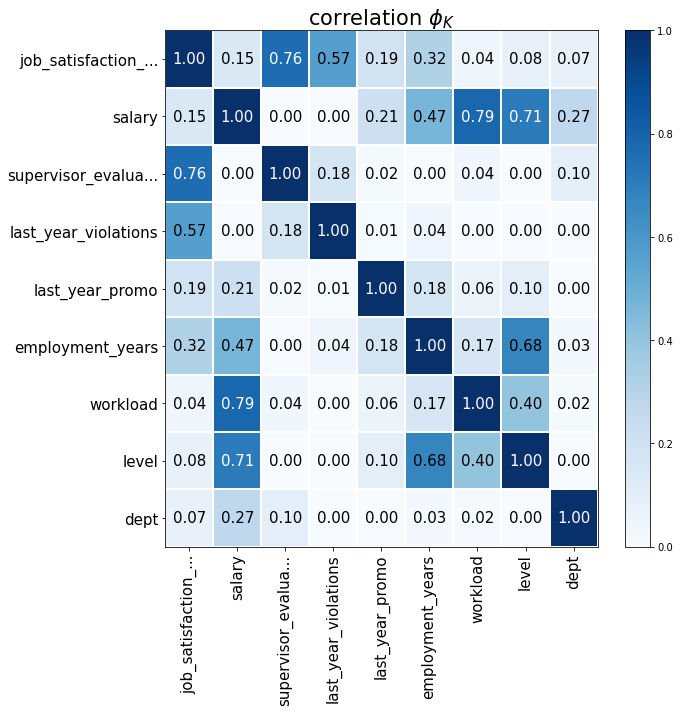

In [ ]:
# Матрица phik

interval_cols = df_train.select_dtypes(exclude = 'object').columns
phik_overview = phik_matrix(df_train, interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(10, 10)
)

### Вывод

**Мультиколлинеарности нет.**

## Подготовка данных

In [ ]:
df_train.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


In [ ]:
X_train = df_train.drop('job_satisfaction_rate', axis = 1)
y_train = df_train['job_satisfaction_rate']

In [ ]:
ord_cols = ['level','workload']
ohe_cols = ['dept', 'last_year_promo', 'last_year_violations']
num_cols = df_train.select_dtypes(exclude = 'object').columns.drop('job_satisfaction_rate')

In [ ]:
ohe_pipe = Pipeline(
[
    ('SimpleImputer_ohe',
    SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('SimpleImputer_2',
    SimpleImputer(missing_values= ' ', strategy='most_frequent')),
    ('ohe',
    OneHotEncoder(drop = 'first', handle_unknown='error'))
]
)

ord_pipe = Pipeline(
[
    ('SimpleImputer_bOE',
    SimpleImputer(missing_values = np.nan, strategy ='most_frequent')),
    ('OE',
    OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = np.nan)),
    ('SimpleImputer_aOE',
    SimpleImputer(missing_values = np.nan, strategy ='most_frequent'))
]
)

preprocessor = ColumnTransformer(
[
    ('ohe', ohe_pipe, ohe_cols),
    ('ord', ord_pipe, ord_cols),
    ('num', StandardScaler(), num_cols)
],
    remainder='passthrough'
)

In [ ]:
param_grid = [
    {
       'model' : [SVR()],
       'model__kernel' : ['poly', 'rbf', 'sigmoid', 'precomputed'],
       'model__degree' : range(1,4),
       'preprocessor__num' : [StandardScaler(),
                           MinMaxScaler(),
                           RobustScaler(),
                           'passthrough']
    },

    {
        'model' : [GradientBoostingRegressor()],
        'model__n_estimators' : range(100, 300, 10),
        'model__max_depth' : range(1,30),
        'model__min_samples_split' : range(2,30),
        'model__min_samples_leaf' : range(1,30),
        'preprocessor__num' : [StandardScaler(),
                           MinMaxScaler(),
                           RobustScaler(),
                           'passthrough']
    },
    {
        'model' : [DecisionTreeRegressor(random_state = RANDOM_STATE)],
        'model__max_depth' : range(1,30),
        'model__min_samples_split' : range(2,30),
        'model__min_samples_leaf' : range(1,30),
        'preprocessor__num' : [StandardScaler(),
                           MinMaxScaler(),
                           RobustScaler(),
                           'passthrough']
    }
]

In [ ]:
full_pipe = Pipeline(
[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
]
)

In [ ]:
def smape(A, F):
    return 100/abs(len(A)) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
smape_scorer = make_scorer(smape, greater_is_better=False)

In [ ]:
randomized_search = RandomizedSearchCV(
    full_pipe,
    param_distributions=param_grid,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

## Обучение моделей

In [ ]:
randomized_search.fit(X_train, y_train)

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.


RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('SimpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('SimpleImputer_2',
                                                                                                SimpleImputer(missing_values=' ',
                                                                                                              strategy='most_frequent')),
                                                                                               ('ohe',
                      

In [ ]:
model = randomized_search.best_estimator_

In [ ]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('SimpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('SimpleImputer_2',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                             

In [ ]:
randomized_search.best_score_

-12.093799828729573

In [ ]:
y_pred = model.predict(df_test.drop('job_satisfaction_rate', axis = 1))
smape(df_test['job_satisfaction_rate'], y_pred)

11.265713870905124

### Вывод

**Лучше всего себя показал градиентный бустинг. SMAPE 11.27**

# Предсказание ухода сотрудника из компании
**Создание модели классификации**

`Целевая метрика ROC-AUC >=91`

## Загрузка данных

In [ ]:
df_train = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv').set_index('id')

In [ ]:
df_test1 = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv').set_index('id')

In [ ]:
df_test = df_test.join(df_test1, how = 'inner')

In [ ]:
df_test

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
686555,hr,junior,medium,1,no,no,4,30000,0.72,no
467458,sales,middle,low,5,no,no,4,19200,0.64,no
418655,sales,middle,low,6,no,no,4,19200,0.60,no
789145,hr,middle,medium,5,no,no,5,40800,0.75,no
...,...,...,...,...,...,...,...,...,...,...
497976,technology,middle,medium,3,no,no,4,52800,0.70,no
393147,marketing,junior,low,3,no,no,3,20400,0.56,yes
109582,technology,middle,low,3,no,no,2,21600,0.14,yes


In [ ]:
df_train

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no
...,...,...,...,...,...,...,...,...,...
588809,sales,junior,medium,4,no,no,3,26400,no
672059,sales,middle,high,9,no,no,4,52800,no
536432,purchasing,junior,low,2,no,yes,4,12000,yes


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 723290 to 853842
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(3), object(6)
memory usage: 312.5+ KB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1917 entries, 485046 to 771859
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   1915 non-null   object 
 1   level                  1916 non-null   object 
 2   workload               1917 non-null   object 
 3   employment_years       1917 non-null   int64  
 4   last_year_promo        1917 non-null   object 
 5   last_year_violations   1917 non-null   object 
 6   supervisor_evaluation  1917 non-null   int64  
 7   salary                 1917 non-null   int64  
 8   job_satisfaction_rate  1917 non-null   float64
 9   quit                   1917 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 164.7+ KB


### Вывод

**В данных есть Nan, для удобства создана таблица df_test с входным и целевым признаками для тестирования модели. Стандартизация имён столлбцов не требуется.**

### Предобработка

In [ ]:
df_train.duplicated().sum()

1413

In [ ]:
df_test.duplicated().sum()

0

In [ ]:
df_train = df_train.drop_duplicates()

### Вывод

**Дубликаты удалены, Nan будут удалены позже в пайплайне.**

## Исследовательский анализ

### Численные признаки

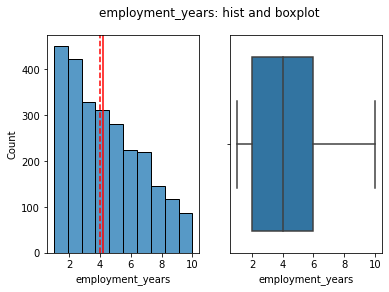

count    2587.000000
mean        4.213375
std         2.601105
min         1.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


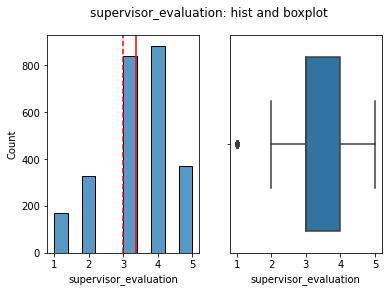

count    2587.000000
mean        3.367994
std         1.080243
min         1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


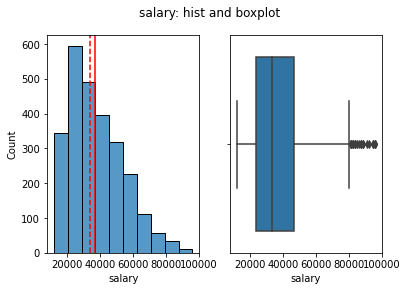

count     2587.000000
mean     37107.692308
std      16267.354906
min      12000.000000
25%      24000.000000
50%      33600.000000
75%      46800.000000
max      96000.000000
Name: salary, dtype: float64


In [ ]:
for i in df_train.columns:
    numgraph(df_train[i])

**В основном, признаки распределены ненормально, для корр. анализа следует использовать $\phi_K$.**

### Категориальные признаки

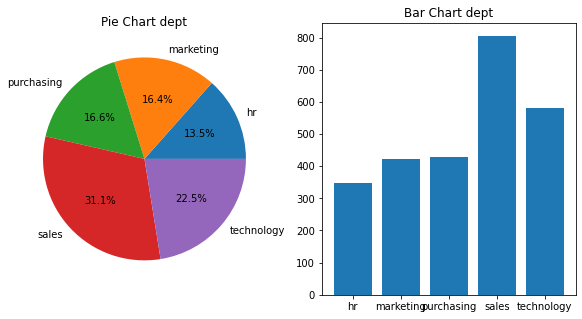

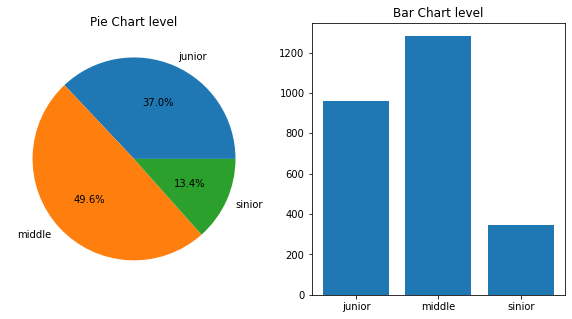

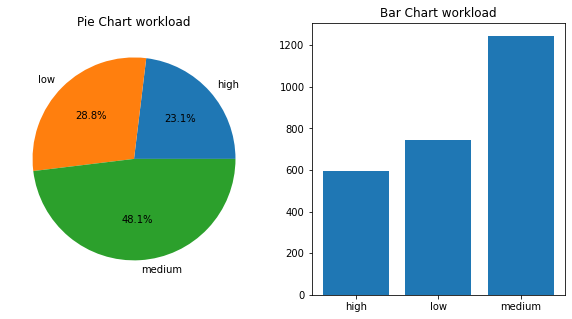

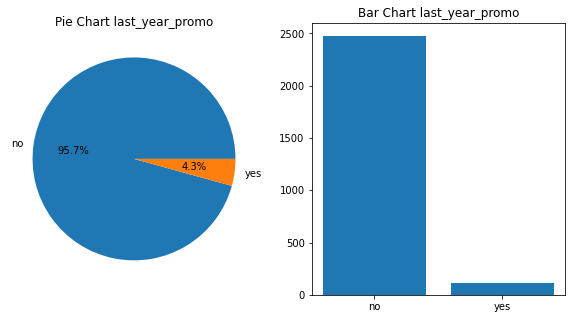

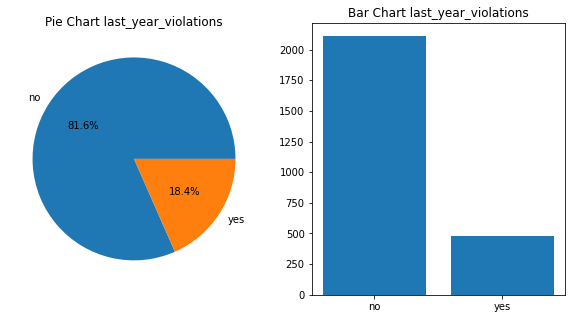

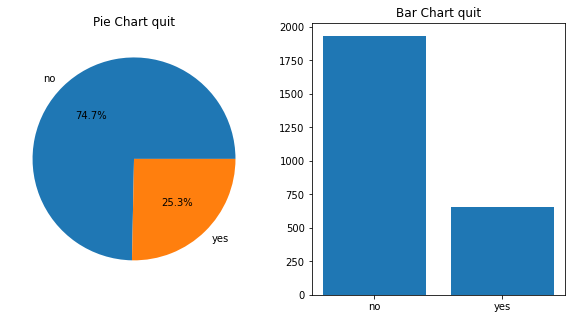

In [ ]:
for i in df_train.select_dtypes(include = 'object').columns:
        catgraph(df_train, df_train[i])

**Есть дисбаланс классов, уместно использовать ROC-AUC для оценки модели.**

### Портрет «уволившегося сотрудника»

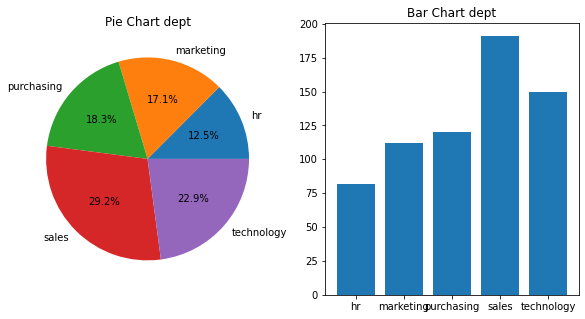

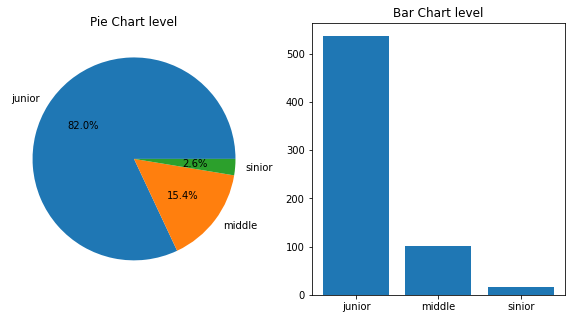

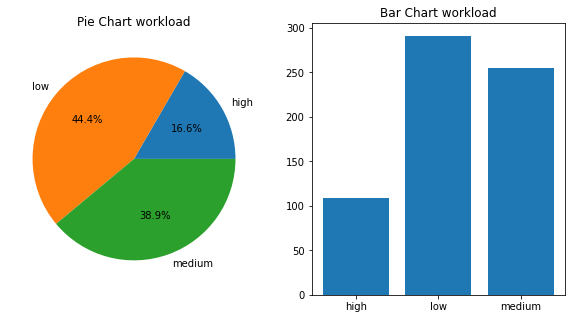

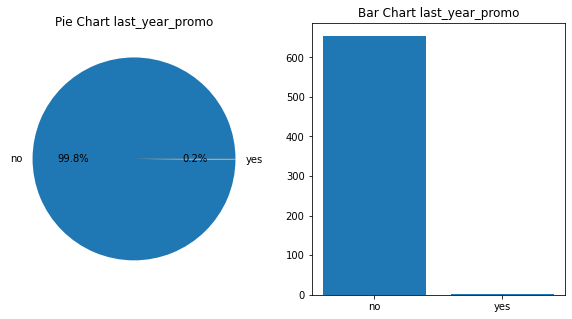

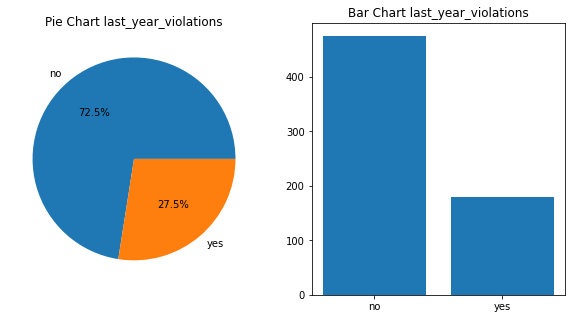

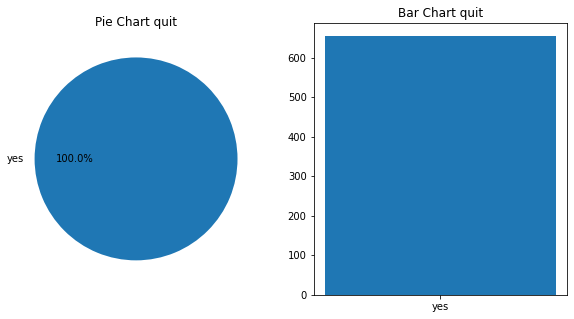

In [ ]:
for i in df_train.select_dtypes(include = 'object').columns:
        catgraph(df_train[df_train['quit'] == 'yes'], df_train[i])

**Уходят больше всего из отделов 'sales' и 'technology', на что следует обратить внимание. Самое же интересное, что уходят в основном младшие позиции с низкой и средней загрузкой, не получавшие повышений за год. Вероятно, причиной ухода в основном становится отсутствие возможностей карьерного роста ввиду нехватки задач.**

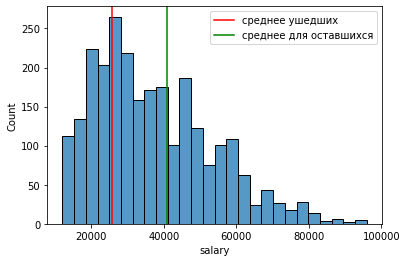

In [ ]:
fig = sns.histplot(
    df_train['salary']
    );

fig.axvline(
    df_train[df_train['quit'] == 'yes']['salary'].mean(),
    color='r',
    label = 'среднее ушедших');

fig.axvline(
    df_train[df_train['quit'] == 'no']['salary'].mean(),
    color='g',
    label = 'среднее для оставшихся');

plt.legend()

**Зарплаты ушедших явно в среднем ниже, в купе с прошлым выводом это даёт нам портрет недостаточно загруженного задачами junior/middle сотрудника, который не видит в компании возможностей для карьерного роста, однако имеет амбиции такого рода.**

In [ ]:
quit_grouped = df_train.groupby('dept')['quit'].value_counts().unstack().fillna(0)
quit_grouped['quit_rate'] = (quit_grouped['yes'] / (quit_grouped['yes'] + quit_grouped['no'])) * 100
quit_grouped['sum'] = quit_grouped['yes'] + quit_grouped['no']
for dept in quit_grouped.index:
    quit_rate = quit_grouped.loc[dept, 'quit_rate']
    total_employees = quit_grouped.loc[dept, 'sum']
    quit_total = quit_grouped.loc[dept, 'yes']

    print(f"доля увольнений от {total_employees} сотрудников {dept} = {round(quit_rate,1)}%, всего уволилось {quit_total}")

доля увольнений от 348 сотрудников hr = 23.6%, всего уволилось 82
доля увольнений от 423 сотрудников marketing = 26.5%, всего уволилось 112
доля увольнений от 430 сотрудников purchasing = 27.9%, всего уволилось 120
доля увольнений от 805 сотрудников sales = 23.7%, всего уволилось 191
доля увольнений от 581 сотрудников technology = 25.8%, всего уволилось 150


**доля увольнений от 464 сотрудников hr = 25.0%, всего уволилось 464**

**доля увольнений от 582 сотрудников marketing = 28.0%, всего уволилось 582**

**доля увольнений от 588 сотрудников purchasing = 28.2%, всего уволилось 588**

**доля увольнений от 1438 сотрудников sales = 28.3%, всего уволилось 1438**

**доля увольнений от 928 сотрудников technology = 29.7%, всего уволилось 928**


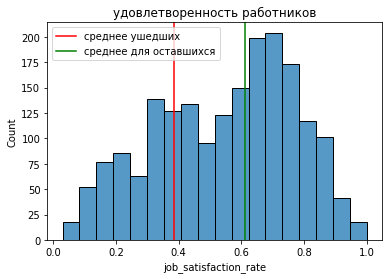

In [ ]:
fig = sns.histplot(
    df_test['job_satisfaction_rate']
    );

plt.title('удовлетворенность работников')

fig.axvline(
    df_test[df_test['quit'] == 'yes']['job_satisfaction_rate'].mean(),
    color='r',
    label = 'среднее ушедших');

fig.axvline(
    df_test[df_test['quit'] == 'no']['job_satisfaction_rate'].mean(),
    color='g',
    label = 'среднее для оставшихся');

plt.legend()

**Выглядит правдоподобно, чем ниже удволетворённость - тем выше риск ухода. Следует использовать признак 'job_satisfaction_rate' для моделирования.**

## Корреляционный анализ

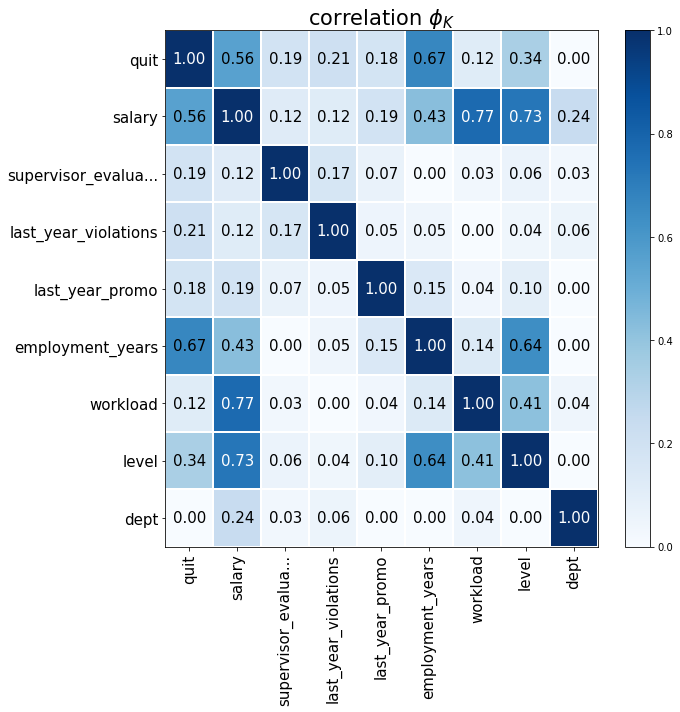

In [ ]:
# Матрица phik

interval_cols = df_test.select_dtypes(exclude = 'object').columns
phik_overview = phik_matrix(df_train, interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(10, 10)
)

**мультиколлинеарности нет.**

## Добавление нового признака

In [ ]:
df_train['job_satisfaction_rate'] = model.predict(df_train.drop('quit', axis = 1))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Подготовка данных для моделирования

In [ ]:
X_train = df_train.drop('quit', axis = 1)
y_train = df_train['quit']

In [ ]:
ord_cols = ['level','workload']
ohe_cols = ['dept', 'last_year_promo', 'last_year_violations']
num_cols = df_train.select_dtypes(exclude = 'object').columns

In [ ]:
ohe_pipe = Pipeline(
[
    ('SimpleImputer_ohe',
    SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('SimpleImputer_2',
    SimpleImputer(missing_values= ' ', strategy='most_frequent')),
    ('ohe',
    OneHotEncoder(drop = 'first', handle_unknown='error'))
]
)
ord_pipe = Pipeline(
[
    ('SimpleImputer_bOE',
    SimpleImputer(missing_values = np.nan, strategy ='most_frequent')),
    ('OE',
    OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = np.nan)),
    ('SimpleImputer_aOE',
    SimpleImputer(missing_values = np.nan, strategy ='most_frequent'))
]
)

preprocessor = ColumnTransformer(
[
    ('ohe', ohe_pipe, ohe_cols),
    ('ord', ord_pipe, ord_cols),
    ('num', StandardScaler(), num_cols)
],
    remainder='passthrough'
)

In [ ]:
param_grid = [
    {
        'model' : [KNeighborsClassifier()],
        'model__n_neighbors' : range(1,30),
        'preprocessor__num' : [StandardScaler(),
                           MinMaxScaler(),
                           RobustScaler(),
                           'passthrough']
    },
    {
        'model' : [DecisionTreeClassifier(random_state = RANDOM_STATE)],
        'model__max_depth' : range(1,30),
        'model__min_samples_split' : range(2,30),
        'model__min_samples_leaf' : range(1,30),
        'preprocessor__num' : [StandardScaler(),
                           MinMaxScaler(),
                           RobustScaler(),
                           'passthrough']
    },
    {
        'model' : [LogisticRegression(random_state = RANDOM_STATE)],
        'model__C' : range(1,30),
        'model__solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
        'preprocessor__num' : [StandardScaler(),
                           MinMaxScaler(),
                           RobustScaler(),
                           'passthrough']
    },
    {
        'model' : [SVC(random_state = RANDOM_STATE, probability= True)],
        'model__kernel' : ['poly', 'rbf', 'sigmoid', 'precomputed'],
        'model__degree' : range(1,4),
        'preprocessor__num' : [StandardScaler(),
                           MinMaxScaler(),
                           RobustScaler(),
                           'passthrough']
    }
]

In [ ]:
full_pipe = Pipeline(
[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression())
]
)

In [ ]:
randomized_search = RandomizedSearchCV(
    full_pipe,
    param_distributions=param_grid,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

## Обучение моделей

In [ ]:
randomized_search.fit(X_train, y_train)

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.


RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('SimpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('SimpleImputer_2',
                                                                                                SimpleImputer(missing_values=' ',
                                                                                                              strategy='most_frequent')),
                                                                                               ('ohe',
                      

In [ ]:
clf = randomized_search.best_estimator_
randomized_search.best_score_

0.9052357749551561

In [ ]:
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('SimpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('SimpleImputer_2',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                             

In [ ]:
roc_auc_score(df_test['quit'], clf.predict_proba(df_test.drop('quit', axis = 1))[:,1])

0.927382976697365

### Вывод

**Лучше всего себя показала модель DecisionTreeClassifier, показав ROC-AUC ~0.93.**

# Общий вывод

## В процессе работы над проектом были выполнены следующие задачи:

1. **Предсказан уровень удовлетворённости сотрудников(модель регрессии)**

2. **Предсказано увольнение сотрудника из компании(модель классификации)**

## Проект состоял из следющих этапов для каждой задачи:

1. **Загрузка данных**
2. **Предобработка данных**
3. **ИАД**
4. **КАД**
5. **Подготовка данных**
6. **Обучение модели**

## Выводы и предложения:

1. **Портрет увольняющегося сотрудника**: Junior/Middle специалист, имеющий амбиции карьерного роста, однако не получающий достаточно нагрузки, и, как следствие, повышение.
2.  **доля увольнений от 464 сотрудников hr = 25.0%, всего уволилось 464**

    **доля увольнений от 582 сотрудников marketing = 28.0%, всего уволилось 582**
    
    **доля увольнений от 588 сотрудников purchasing = 28.2%, всего уволилось 588**
    
    **доля увольнений от 1438 сотрудников sales = 28.3%, всего уволилось 1438**
    
    **доля увольнений от 928 сотрудников technology = 29.7%, всего уволилось 928**


3. Система оценки удовлетворённости работает: видна явная связь между уходом сотрудника из компании и низкой удовлетворённостью